In [6]:
import io
import pandas as pd
df = pd.read_csv('fods_1.csv')
df = df.sample(frac = 1)

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from random import randint

In [8]:
df

,MLOGP,RDCHI,quantitative response of LC50
163,3.026,2.828,4.339
67,5.208,3.691,6.383
181,1.246,2.046,5.642
544,2.859,2.614,4.995
32,2.026,1.265,3.577
...,...,...,...
293,3.907,3.934,9.063
528,2.378,2.472,3.474
124,1.533,2.056,3.481
509,6.232,2.766,7.509


Normalising the values

In [9]:
df=(df-df.mean())/df.std()
df

,MLOGP,RDCHI,quantitative response of LC50
163,0.409064,0.413933,-0.191820
67,1.661793,1.478046,1.035649
181,-0.612868,-0.550304,0.590662
544,0.313186,0.150063,0.202123
32,-0.165055,-1.513308,-0.649418
...,...,...,...
293,0.914864,1.777675,2.645051
528,0.037035,-0.025029,-0.711272
124,-0.448096,-0.537973,-0.707069
509,2.249692,0.337485,1.711838


80-20 train-test split

In [10]:
train_data = df.iloc[:436]
test_data = df.iloc[436:]

train_data = train_data.to_numpy()
test_data = test_data.to_numpy()

M_train = train_data[:,[0]]
G_train = train_data[:,[1]] 
L_train = train_data[:,[2]]

M_test = test_data[:,[0]]
G_test = test_data[:,[1]] 
L_test = test_data[:,[2]]

In [11]:
def generateValuesMatrix(req_deg, M, G, L):
  n = M.shape[0]
  data_points = np.ones(n, dtype = np.float64).reshape(-1,1)
  i = 1
  while(i <= req_deg):
      length = (int)((i+1)*(i)/2)
      temp = data_points[:, length-i:]
      temp = temp * M
      data_points = np.concatenate((data_points, temp, pow(G, i)), axis = 1)
      i = i + 1
  data_points = np.concatenate((data_points, (-1)*L), axis=1)
  return data_points

In [12]:
def input_function():
  degree = int(input("Enter the required degree: "))
  isStochastic = bool(int(input("Which Algorithm:\n0. Normal Gradient Descent\n1. Stochastic Gradient Descent\n")))
  regularisation = float(input("Enter the value of q\n"))
  la = 0
  if regularisation != 0:
    la = float(input("Lambda for regularisation: "))
  iterations = int(input("Number of iterations: "))
  learningRate = float(input("Learning rate(Eta): "))
  return (degree, isStochastic, regularisation, iterations, learningRate, la)

In [13]:
def plotting_function(degree, coefficients):
  # Creating dataset
  x = np.outer(np.linspace(M_train.min(), G_train.max(), 100), np.ones(100))
  y = np.outer(np.linspace(G_train.min(), G_train.max(), 100), np.ones(100)).T
  i = 1
  j = 1
  z = coefficients[0][0]*pow(x,0)*pow(y,0)
  while i <= degree:
    temp = i
    while temp >= 0:
      z = z + coefficients[j][0] * pow(x, temp) * pow(y, i - temp)
      temp=temp-1
      j = j + 1
    i=i+1

  print(j)
  
  # Creating figure
  fig = plt.figure(figsize =(14, 9))
  ax = plt.axes(projection ='3d')

  # creating plot 
  ax.scatter3D(M_train, G_train, L_train, color = 'red')
  ax.plot_surface(x,y,z,color='green')
  
  # show plot
  plt.show()

In [14]:
def gradientDescent():
  req_deg, isStochastic, regularisation, no_of_iterations, eta, la = input_function()
  data_train = generateValuesMatrix(req_deg, M_train, G_train, L_train)
  data_test = generateValuesMatrix(req_deg, M_test, G_test, L_test)
  n_coeffs = (req_deg + 1) * (req_deg + 2) // 2
  coeffecients = np.ones(n_coeffs+1).reshape(-1,1) # Initializing coefficient matrix
  coeffecients[n_coeffs] = 1 # To consider the pressure value
  trainingerror = 1000000 # garbage value
  testingerror = 10000000 # garbage value
  for _ in range(no_of_iterations):
      
      # Matrix Multiplying coeffcients with data points
      if isStochastic:
        inde = randint(0, 435)
        intermediate_matrix = data_train[inde,:].dot(coeffecients)
      else:
        intermediate_matrix = data_train.dot(coeffecients)

      if(_ % 100) == 0:
          training_error = intermediate_matrix * intermediate_matrix
          if isStochastic:
            temp = data_train.dot(coeffecients)
            training_error = temp * temp
          inter_test = data_test.dot(coeffecients)
          testing_error = inter_test * inter_test
          new_train = training_error.sum()
          new_test = testing_error.sum()
          if new_train < trainingerror:
            trainingerror = new_train
          if new_test < testingerror:
            testingerror = new_test
          print(f"(Training, Testing) error  for {_}th iteration is ({new_train}, {new_test})")
      slope = np.zeros(n_coeffs)
      la_matrix = np.zeros(n_coeffs)
      j = 0
      while(j < n_coeffs):
          if isStochastic:
            slope[j] = float((intermediate_matrix*data_train[inde, [j]]).sum())
          else:
            slope[j] = float((intermediate_matrix*data_train[:, [j]]).sum())
          la_matrix[j] = ( abs(coeffecients[j][0]) / coeffecients[j][0] )*float(la)
          j = j+1
      slope = slope.reshape(-1,1) # Making it a column
      la_matrix = la_matrix.reshape(-1,1)

      if regularisation == 2: # regularisation = 2 for ridge regression
        slope = slope + (la_matrix*coeffecients[:-1, :])          
      elif regularisation == 1: # regularisation = 1 for lasso regression
        slope = slope + la_matrix
      elif regularisation == 5: # regularisation = 0.5 for lasso regression
        slope = slope + la_matrix*(np.sqrt(coeffecients[:-1, :])/coeffecients[:-1, :])
      elif regularisation == 4: # regularisation = 4 for lasso regression
        slope = slope + la_matrix*((coeffecients[:-1, :])*(coeffecients[:-1, :])*(coeffecients[:-1, :]))
        
      # regularisation = 0 for no regularisation

      coeffecients[:-1, :] = coeffecients[:-1, :] - (eta)*slope # Gradient Descent Formula
  print(coeffecients)
  print(trainingerror, testingerror)
  plotting_function(degree=req_deg, coefficients=coeffecients)
  return coeffecients

Enter the required degree: 3
Which Algorithm:
0. Normal Gradient Descent
1. Stochastic Gradient Descent
0
Enter the value of q
0.5
Lambda for regularisation: 0.000009
Number of iterations: 1000
Learning rate(Eta): 0.000002
(Training, Testing) error  for 0th iteration is (136980.17995627283, 21985.215248617227)
(Training, Testing) error  for 200th iteration is (1322.8459355877312, 435.140831010542)
(Training, Testing) error  for 400th iteration is (664.9435665025203, 199.56566731742134)
(Training, Testing) error  for 600th iteration is (470.56627065007166, 141.8111402617137)
(Training, Testing) error  for 800th iteration is (401.4007023717201, 118.54161419625856)
[[ 0.30875985]
 [ 0.70190966]
 [ 0.74204941]
 [-0.10439748]
 [ 0.18733108]
 [-0.030256  ]
 [-0.05130557]
 [-0.01594779]
 [-0.03608475]
 [-0.04850581]
 [ 1.        ]]
401.4007023717201 118.54161419625856
10


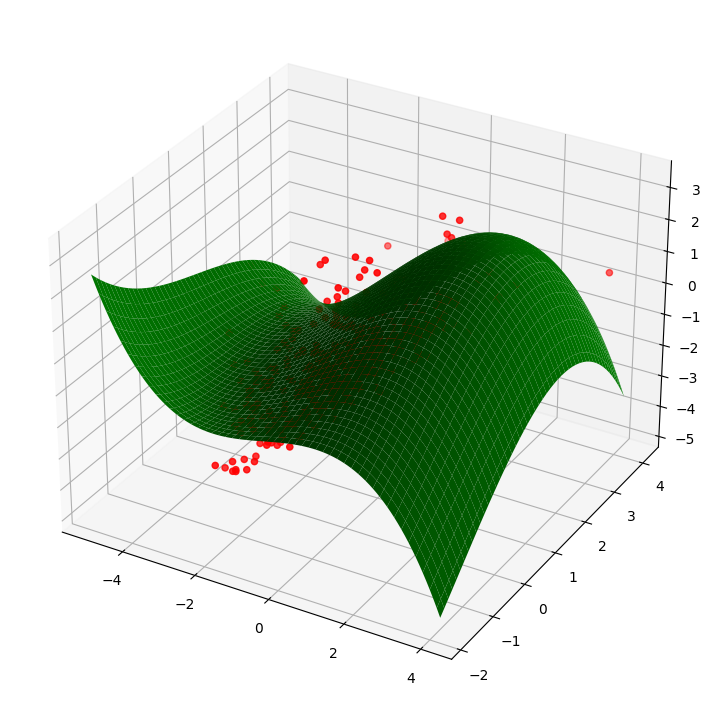

array([[ 0.30875985],
       [ 0.70190966],
       [ 0.74204941],
       [-0.10439748],
       [ 0.18733108],
       [-0.030256  ],
       [-0.05130557],
       [-0.01594779],
       [-0.03608475],
       [-0.04850581],
       [ 1.        ]])

In [15]:
gradientDescent()